# Introduction

## Challenge Test


# Image Classification:

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.



1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

# The properties of the dataset:

DataSet consistst of images of faces of different persons with certain characteristics. The task is to train a model able to predict whether certain image possess required chacteristics (encoded by the output labels) or not.
There is imbalance between the sample images in the dataset for men and women.

### Downloading the Data: 

DataSet is with the Email


After unzipping the file, you have three folders: train, validation, test and two text files relating to the train and validation labels. You can use both training and validation data for training and validation your model.

### Training and Validation Data

***Training Data:*** The "train" folder contains 1000 face images numbered from 000000 to 000999. These are color images in .jpg format with size of 80x80 pixels.

***Training Labels:*** The file named "label_train.txt" contains two columns. The first column list the 1000 labels (0 or 1) that are used to train your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

***Validation Data:*** The "validation" folder contains 500 face images numbered from 000000 to 000500. These are color images in .jpg format with size of 80x80 pixels.

***Validation Labels:*** The file named "label_validation.txt" contains two columns. The first column list the 500 labels (0 or 1) that are used to validate your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

### Test Data

 The "test" folder contains 500 face images numbered from 000000 to 000499. These are color images in .jpg format with size of 80x80 pixels.

### Example Submission

In [63]:
import glob, os, re
import cv2
import keras
import numpy as np
from keras import models, layers, optimizers
from keras.utils import np_utils
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import random
import plotly.express as px
import itertools
import plotly.graph_objects as go
import matplotlib.cm as cm
from IPython.display import Image

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# We retrieve the data from Google Drive as we use Google Colab to leverage GPU execution
TRAIN_IMAGES_PATH = "/content/drive/MyDrive/hiparis/DataSet/train/"
VALIDATION_IMAGES_PATH = "/content/drive/MyDrive/hiparis/DataSet/Validation/"
TEST_IMAGES_PATH = "/content/drive/MyDrive/hiparis/DataSet/test/"

TRAIN_IMAGES_LABELS_PATH = "/content/drive/MyDrive/hiparis/DataSet/label_train.txt"
VALIDATION_IMAGES_LABELS_PATH = "/content/drive/MyDrive/hiparis/DataSet/label_validation.txt"

resizing_height = 80
resizing_width = 80
class_to_name = {
    0: "Label 0",
    1: "Label 1",
}

# Set "notebook" if run in a notebook
render_mode = "colab"

### Data prep

In [66]:
train_labels = pd.read_csv(TRAIN_IMAGES_LABELS_PATH, sep=" ", header=None)
train_labels.columns = ["label", "gender"]

validation_labels = pd.read_csv(VALIDATION_IMAGES_LABELS_PATH, sep=" ", header=None)
validation_labels.columns = ["label", "gender"]

In [67]:
def vectorize_images(IMAGES_PATH, nb_of_images, resizing_height, resizing_width):
    img = cv2.imread(os.path.join(IMAGES_PATH, "000000.jpg"))
    resized = cv2.resize(img, (resizing_height, resizing_width), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    imgs = np.array(img)
    for i in range (1, nb_of_images):
      image_index = i
      while len(str(image_index)) < 6 :
        image_index = "0" + str(image_index)
      img = cv2.imread(os.path.join(IMAGES_PATH, image_index + ".jpg"))
      resized = cv2.resize(img, (resizing_height, resizing_width), interpolation = cv2.INTER_AREA)
      img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
      img = np.array(img)
      imgs = np.concatenate((imgs, img))
    return imgs

In [68]:
def normalize(imgs):
    train_norm = imgs.astype('float32') / 255.0
    return train_norm

In [69]:
def reshape_and_normalize(IMAGE_PATH, labels):
  imgs = vectorize_images(IMAGE_PATH, labels.shape[0], resizing_height, resizing_width)
  imgs = imgs.reshape((labels.shape[0], resizing_height, resizing_width, 3))
  imgs = normalize(imgs)
  return imgs

In [213]:
X_train = reshape_and_normalize(TRAIN_IMAGES_PATH, train_labels)
y_train_label = train_labels["label"].to_numpy()
y_train_gender = train_labels["gender"].to_numpy()

X_val = reshape_and_normalize(VALIDATION_IMAGES_PATH, validation_labels)
y_val_label = validation_labels["label"].to_numpy()
y_val_gender = validation_labels["gender"].to_numpy()

X_test = reshape_and_normalize(TEST_IMAGES_PATH, validation_labels)

### Visualize a sample of the dataset

In [214]:
def show_data(x, y):
    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        index = random.randint(0, y.shape[0])
        plt.subplot(3, 6, i + 1)
        plt.imshow(x[index], cmap="gray")
        color = "blue" if y[index] == 1 else "orange"
        plt.text(0, 2, s=f"label={class_to_name[y[index]]}",
                 bbox=dict(facecolor=color, alpha=0.9),
                 color="white")
        plt.axis("off")
    plt.show()

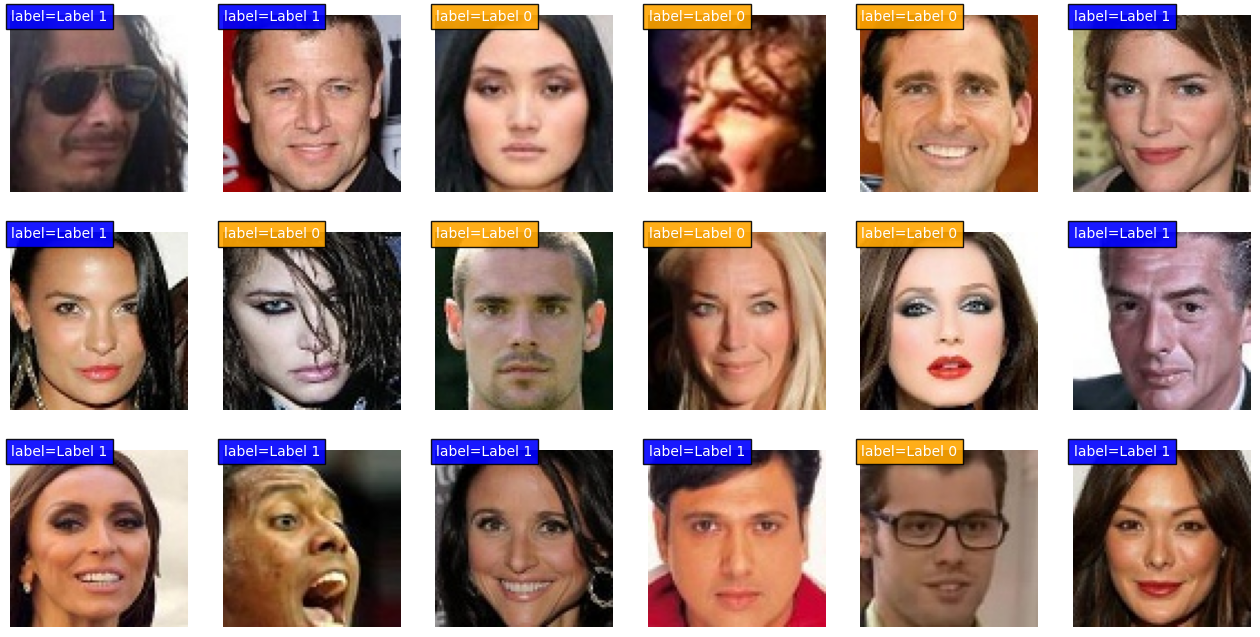

In [215]:
show_data(X_train, y_train_label)

The task of binary classifying images is more complicated here as we don't know what we try to classify.

**There is no explicit difference between classes guessable by looking at the images.**

### Distribution of genders among the classes

In [216]:
df_train_label_0 = train_labels[train_labels["label"] == 0]
df_train_label_1 = train_labels[train_labels["label"] == 1]
df_train_man_label_0 = df_train_label_0[df_train_label_0["gender"] == 1]
df_train_woman_label_0 = df_train_label_0[df_train_label_0["gender"] == 0]
df_train_man_label_1 = df_train_label_1[df_train_label_1["gender"] == 1]
df_train_woman_label_1 = df_train_label_1[df_train_label_1["gender"] == 0]

df_val_label_0 = validation_labels[validation_labels["label"] == 0]
df_val_label_1 = validation_labels[validation_labels["label"] == 1]
df_val_man_label_0 = df_val_label_0[df_val_label_0["gender"] == 1]
df_val_woman_label_0 = df_val_label_0[df_val_label_0["gender"] == 0]
df_val_man_label_1 = df_val_label_1[df_val_label_1["gender"] == 1]
df_val_woman_label_1 = df_val_label_1[df_val_label_1["gender"] == 0]

In [217]:
def vis_gender_class_distribution(df_man_label_0, df_man_label_1, df_woman_label_0, df_woman_label_1):
  # Data
  groups = ['Label 0', 'Label 1']
  values1 = [df_man_label_0.shape[0], df_man_label_1.shape[0]]
  values2 = [df_woman_label_0.shape[0], df_woman_label_1.shape[0]]

  fig, ax = plt.subplots()

  # Stacked bar chart
  ax.bar(groups, values1, label = "Man")
  ax.bar(groups, values2, bottom = values1, label = "Woman")

  # Labels
  for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y(),
            round(bar.get_height()), ha = 'center',
            color = 'w', weight = 'bold', size = 10)

  ax.legend()
  ax.set_ylabel('Occurence')

##### Training set

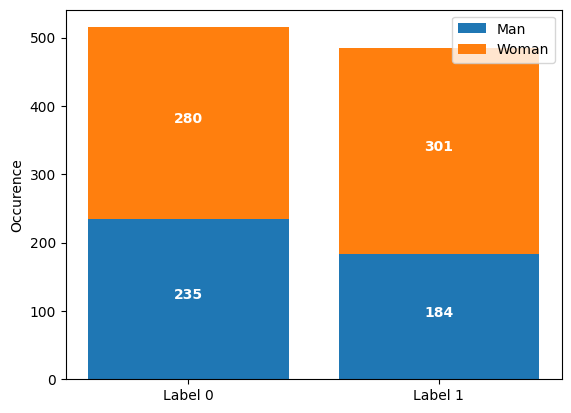

In [218]:
vis_gender_class_distribution(df_train_man_label_0, df_train_man_label_1, df_train_woman_label_0, df_train_woman_label_1)

##### Validation set

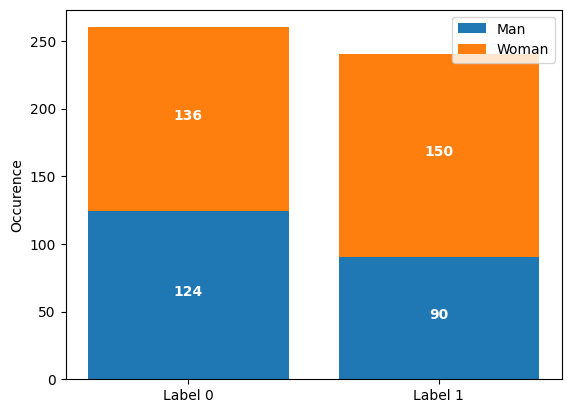

In [219]:
vis_gender_class_distribution(df_val_man_label_0, df_val_man_label_1, df_val_woman_label_0, df_val_woman_label_1)

We can see that women are over-represented in both Label 0 and Label 1, but more significantly in Label 1. This probably means that the characteristics of the Label 1 are more represented in women. This can also mean that the dataset is imbalanced regarding the gender. 

We can remove 30 rows from the label 0 in the training set in order to perfectly balance the classes

### Balance the datasets

In [220]:
index_to_remove = list(df_train_label_0.loc[np.random.choice(df_train_label_0.index, 30, replace=False)].index)

In [221]:
X_train = np.delete(X_train, index_to_remove, 0)
y_train_label = np.delete(y_train_label, index_to_remove, 0)
y_train_gender = np.delete(y_train_gender, index_to_remove, 0)

#### Split validation set to create a test set

In order to be able to detect if the model overfits the validation set, we need a test set with labels. Hence, we retrieve 25% of the validation set to create a test set 

In [222]:
test_sample = validation_labels.sample(frac=0.3)
test_idx = list(test_sample.index)

X_val_sampled = np.delete(X_val, test_idx, 0)
y_val_label_sampled = np.delete(y_val_label, test_idx, 0)
y_val_gender_sampled = np.delete(y_val_gender, test_idx, 0)

filter_arr = []

for i in range(X_val.shape[0]):
  if i in test_idx:
    filter_arr.append(True)
  else:
    filter_arr.append(False)

X_test_local = X_val[filter_arr]
y_test_label_local = test_sample["label"].to_numpy()
y_test_gender_local = test_sample["gender"].to_numpy()

### Data Augmentation
To make our model more robust to overfitting, we perform data augmentation : The idea is to transform a little bit each image by rotating them or zooming in order to extract the most valuable information from it.

In [223]:
aug = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [224]:
imageGen = aug.flow(X_train, y_train_label, batch_size=32)
validGen = aug.flow(X_val_sampled, y_val_label_sampled,  batch_size=32)

In [225]:
def show_ImgGen(imageGen):
    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        x, y = next(imageGen)
        index = random.randint(0, 31)
        plt.subplot(3, 6, i + 1)
        plt.imshow(x[index], cmap="gray")
        color = "blue" if y[index] == 1 else "orange"
        plt.text(0, 2, s=f"label={class_to_name[y[index]]}",
                 bbox=dict(facecolor=color, alpha=0.9),
                 color="white")
        plt.axis("off")
    plt.show()

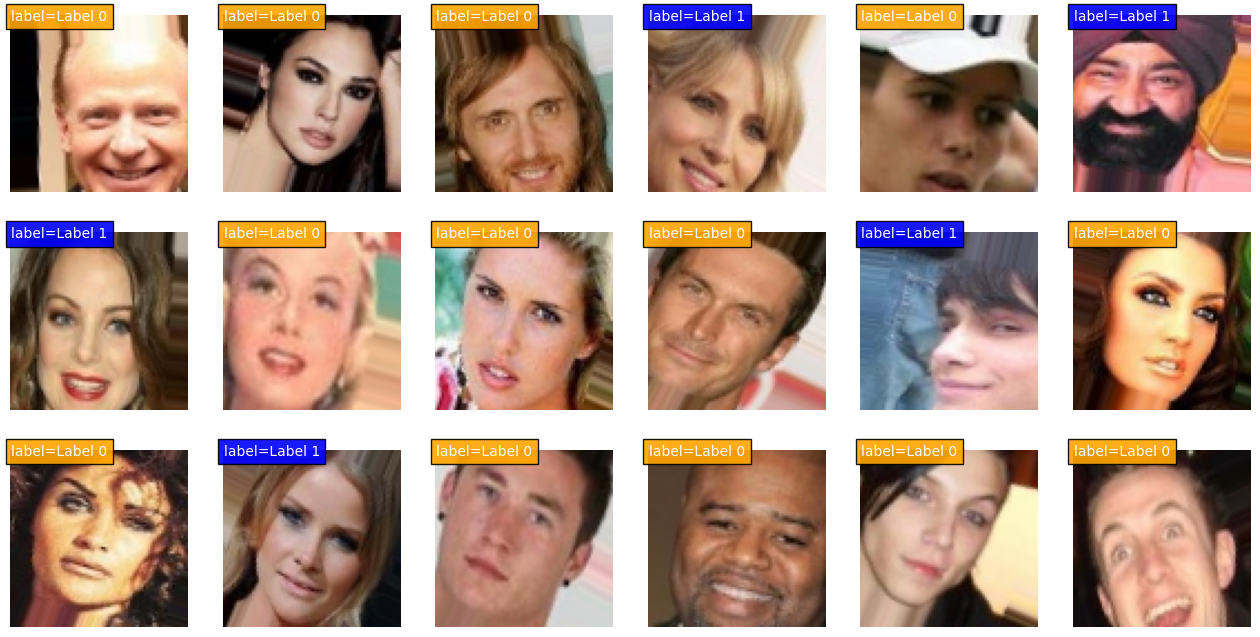

In [226]:
show_ImgGen(imageGen)

### Building your Network

In [227]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, add, Reshape, \
    Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, \
    LeakyReLU, Dropout, Softmax, MaxPool2D, AveragePooling2D, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import typing

Transfer Learning using Xception architecture and imagenet weights

In [259]:
%tensorflow_version 2.x
input_shape=X_train[0].shape

# Load pre-trained VGG16
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
  layer.trainable = False

# Build head
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten(name='flatten_head'))
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(512, activation='relu',name='inter'))
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(1, activation='sigmoid',name='dense_final_head'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

# Define Optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)



# Compile and summarize model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
print('Model compiled')

# Define callbacks
best_model_fname = 'image_classif_transfer_learning_model.h5'
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy',
                                save_best_only=True, verbose=1)

# LR Scheduler 

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 25
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrscheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

epochs = 50
steps = int(X_train.shape[0] / 64)
history = model.fit(imageGen, steps_per_epoch=steps, epochs=epochs, validation_data=(X_val_sampled, y_val_label_sampled), callbacks=[best_model_cb], verbose=2)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 sequential_22 (Sequential)  (None, 1)                 1049601   
                                                                 
Total params: 15,764,289
Trainable params: 1,049,601
Non-trainable params: 14,714,688
_________________________________________________________________
Model compiled
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.52857, saving model to image_classif_transfer_learning_model.h5
15/15 - 4s - loss: 0.9329 - accuracy: 0.4604 - val_loss: 0.6838 - val_accuracy: 0.5286 - 4s/epoch - 273ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.52857
15/15 - 1s - loss: 0.8545 - accuracy: 0.5250 - 

In [260]:
model.load_weights(best_model_fname)
df_model1 = pd.DataFrame(history.history)

### Model Evaluation

In [261]:
#Vizualise Validation and Training Loss evolution during training
def viz_loss_evol(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=df['loss'],
                        mode='lines',
                        name='loss'))
    fig.add_trace(go.Scatter(y=df['val_loss'],
                        mode='lines',
                        name='val_loss'))
    fig.update_layout(title='Loss and val_loss evolution',
                       xaxis_title='Epochs',
                       yaxis_title='Loss')
    fig.show(renderer=render_mode)

In [262]:
#Vizualise Validation and Training Accuracy evolution during training
def viz_acc_evol(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=df['accuracy'],
                        mode='lines',
                        name='accuracy'))
    fig.add_trace(go.Scatter(y=df['val_accuracy'],
                        mode='lines',
                        name='val_accuracy'))
    fig.update_layout(title='Accuracy and val_accuracy evolution',
                       xaxis_title='Epochs',
                       yaxis_title='Accuracy')
    fig.show(renderer=render_mode)

In [263]:
viz_loss_evol(df_model1)

This is the typical plot of losses that don't converge to any minimum. We can't expect much from this model

In [264]:
viz_acc_evol(df_model1)

The learning is not smooth and the model has trouble to converge but still we can observe a progression. 


#### Confusion Matrix

In [265]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('viridis')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [266]:
def get_cm(X_test, y_test, model):
    predict_labels = model.predict(X_test)
    predictions = model.predict(X_test)
    class_pred = []
    for i in range(predictions.shape[0]):
        if predictions[i]>0.5:
            class_pred.append(1)
        else:
            class_pred.append(0)
    class_pred = np.array(class_pred)
    cm = confusion_matrix(y_test, class_pred)
    cm = np.array(cm)
    return cm, class_pred

In [267]:
predict_labels = model.predict(X_test_local)
conf_mat, class_pred = get_cm(X_test_local, y_test_label_local, model)

5/5 [==============================] - 0s 8ms/step


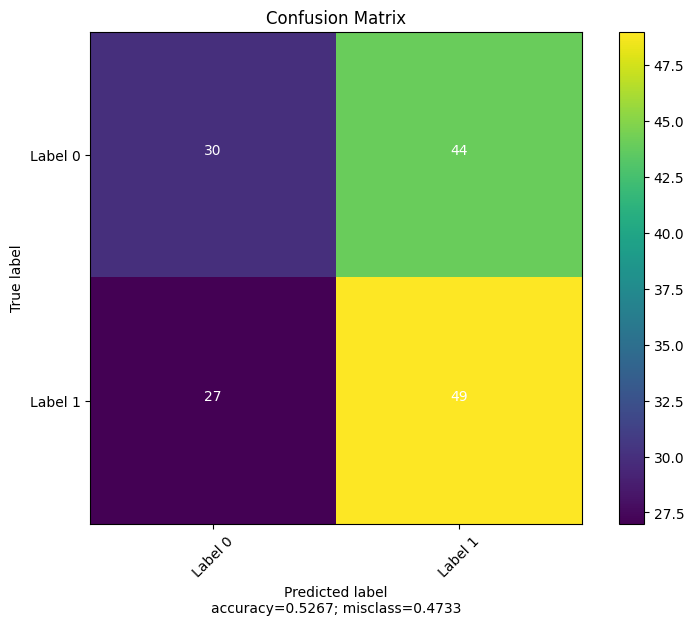

In [268]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['Label 0', 'Label 1'],
                      title        = "Confusion Matrix")

#### F1 Score

In [269]:
from sklearn.metrics import f1_score
f1_sc = f1_score(y_test_label_local, class_pred, average='binary')
print ("The F1-Score is : " + str(f1_sc))

The F1-Score is : 0.5798816568047337


#### ROC Curve

In [270]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [271]:
def generate_results(validation_labels, y_pred):
    fpr, tpr, _ = roc_curve(validation_labels, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

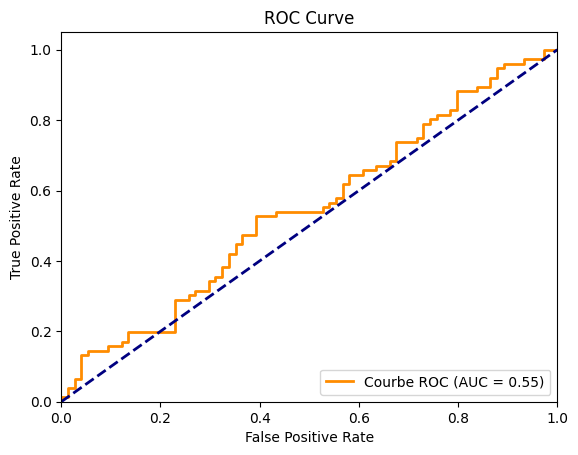

In [272]:
generate_results(y_test_label_local, predict_labels)

### Accuracy by gender in the validation set 

In [278]:

men_index = list(validation_labels[validation_labels["gender"] == 1].index)
women_index = list(validation_labels[validation_labels["gender"] == 0].index)

X_val_men = np.delete(X_val, women_index, 0)
X_val_women = np.delete(X_val, men_index, 0)

y_val_men = np.delete(y_val_label, women_index, 0)
y_val_women = np.delete(y_val_label, men_index, 0)

Men

In [279]:
predict_labels = model.predict(X_val_men)
conf_mat, class_pred = get_cm(X_val_men, y_val_men, model)

7/7 [==============================] - 0s 10ms/step


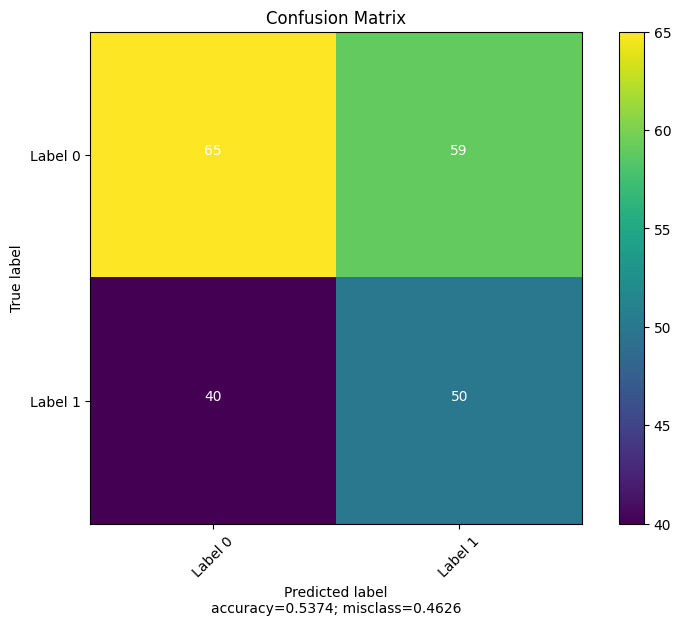

In [280]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['Label 0', 'Label 1'],
                      title        = "Confusion Matrix")

Women

In [281]:
predict_labels = model.predict(X_val_women)
conf_mat, class_pred = get_cm(X_val_women, y_val_women, model)

9/9 [==============================] - 0s 8ms/step


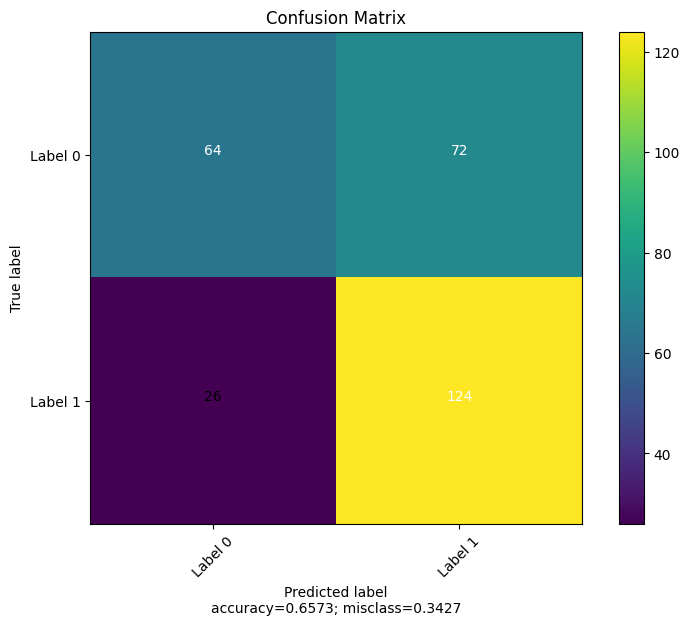

In [282]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['Label 0', 'Label 1'],
                      title        = "Confusion Matrix")

### Preparing your file for Submission

In [283]:
predict_labels = model.predict(X_test)

16/16 [==============================] - 0s 9ms/step


In [284]:
np.save('predict_labels.npy', predict_labels)

### Conclusion




We observed that the model has significantly different results in the validation set depending on the gender of the person in the input image. 

This is probably due to the gender imbalance in the distribution of the genders among the classes as we can see in the distributions of the predictions are the same in the confusion matrix. 

The results of the model is not significantly better that the random classifier and the different metrics used to evaluate the quality of the model are not good. My intuition would be that the classes are not relevant and do not discriminate anything.